# Objetivos principales
1. Describir los datos
2. Desarrollar un sistema de recomendacion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [2]:
df_ratings = pd.read_csv("./data/u_data_ratings.csv",sep=";").drop(["Unnamed: 3"],axis=1)
df_mov_items = pd.read_csv("./data/u_movies_items.csv",encoding="ISO-8859-1",sep="|",header=None)
df_user_info = pd.read_csv("./data/u_user_info.csv",encoding="ISO-8859-1",sep="|",header=None)

## Corrección del nombre de las columnas

In [3]:
# En este dataframe se encuentra la información de cada rating que dieron los usuarios
# NOTA: varios usuarios aparecen varias veces porque dieron varios ratings
# NOTA: varias peliculas aparecen varias veces porque recivieron varios ratings

# User id: usuario
# Item ID: ID de pelicula
# Rating: Calificación de película de 1 a 5
print("Ratings recibidos: ",df_ratings.shape[0])
df_ratings.head()

Ratings recibidos:  65535


,User ID,Item ID,Rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
df_ratings[df_ratings["User ID"] == 196].iloc[0,0]

196

In [5]:
print("Cantidad de películas: ",df_mov_items.shape[0])
df_mov_items.head()

Cantidad de películas:  1682


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
dic2 = {0:"User_ID",1:"Age",2:"Sex",3:"Occupation",4:"dir_postal"}
df_user_info = df_user_info.rename(columns=dic2)
print("Cantidad de usuarios: ",df_user_info.shape[0])
df_user_info.head()

Cantidad de usuarios:  943


,User_ID,Age,Sex,Occupation,dir_postal
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Vemos que hay 943 usuarios en los datos conseguidos

In [7]:
# Renombrando las columnas del data freame de las películas
dic3 = {0:"ID",1:"Name", 2:"rel_date",3:"Unnamed",4:"imdb_link",
        5:"Unknown", 6:"Action", 7:"Adventure", 8:"Animation",
        9:"Children's", 10:"Comedy", 11:"Crime", 12:"Documentary",
        13:"Drama",14:"Fantasy", 15:"Film_Noir", 16: "Horror",
        17:"Musical", 18:"Mystery", 19:"Romance", 20:"Sci_Fi", 21:"Thriller", 22:"War", 23:"Western"
       }
df_mov_items = df_mov_items.rename(columns=dic3) # Corregimos el nombre de las columnas

## 1. Descripción de los datos
Las siguientes son preguntas que nos pueden ayudar a describir los datos que tenemos
1. ¿Cómo se distribuyen las edades de quienes les gustó (4 o 5)/no están seguros (3)/ no les gustó (1 o 2) la película por género de la misma de película?
2. ¿Proporción de personas por ocupación en cada uno de los generos de pelicula?
3. ¿Cuantos son hombres y cuantos son mujeres en cada una de las categorías de película?

### Pregunta 1.1
Lo primero que necesitamos es etiquetar cada rating en si le gustó, no está seguro o no.

In [8]:
# con df_rating
gustos = []
for i in range(len(df_ratings)):
    if df_ratings.iloc[i,2] >=4:
        gustos.append("Like")
    elif df_ratings.iloc[i,2]>=3 and df_ratings.iloc[i,2] < 4:
        gustos.append("No sabe")
    else:
        gustos.append("Dislike")
df_ratings["Gustos"] = gustos

In [9]:
df_ratings["Gustos"].value_counts()

Like       36490
No sabe    17652
Dislike    11393
Name: Gustos, dtype: int64

Una vez etiquetado cada rating, (verificamos primero las proporciones de las clases) separamos estas clases y validamos la distribucion de edad por genero de película con diagrama de cajas y bigotes. (Ayuda: https://seaborn.pydata.org/generated/seaborn.boxplot.html)


In [10]:
df_mov_items.head()

,ID,Name,rel_date,Unnamed,imdb_link,Unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
print(df_mov_items.iloc[:,5:].shape)

(1682, 19)


In [12]:
# Pegamos la edad de las personas cuyo ID corresponde al ID en df_ratings
# Se tarda un rato buscando la informacion
edades = []
for i in range(len(df_ratings)):
    fila = df_user_info.index[df_user_info['User_ID'] == df_ratings.iloc[i,0]].tolist()[0]
    edades.append(df_user_info.iloc[fila,1])

In [13]:
df_ratings["Edad"] = edades
df_ratings.head()

,User ID,Item ID,Rating,Gustos,Edad
0,196,242,3,No sabe,49
1,186,302,3,No sabe,39
2,22,377,1,Dislike,25
3,244,51,2,Dislike,28
4,166,346,1,Dislike,47


In [14]:
print(max(df_ratings["Item ID"]))
print(len(df_mov_items))

1669
1682


In [15]:
# Pegamos el género de la pelicula en la tabla df_ratings - Tarda un rato
generos = np.zeros([len(df_ratings),19])
generos_str = []
for i in range(len(df_ratings)):
    fila = df_mov_items.index[df_mov_items['ID'] == df_ratings.iloc[i,1]].tolist()[0]
    generos[i,:] = df_mov_items.iloc[fila,5:]
    # indices de columnas con 1s
    idx = random.choice(np.where(generos[i,:] == 1)) + 5
    nombre = df_mov_items.columns[idx]
    generos_str.append(nombre)

In [16]:
# Agregando las columnas de los generos a df_ratings:
for i in range(5,24):
    df_ratings[df_mov_items.columns[i]] = generos[:,i-5]
df_ratings

,User ID,Item ID,Rating,Gustos,Edad,Unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,196,242,3,No sabe,49,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,186,302,3,No sabe,39,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,22,377,1,Dislike,25,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,244,51,2,Dislike,28,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,166,346,1,Dislike,47,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65530,739,187,4,Like,35,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65531,787,331,3,No sabe,18,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
65532,683,311,3,No sabe,42,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
65533,807,62,3,No sabe,41,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [65]:
# Pegamos los generos en un string
generos = []
for i in range(len(df_ratings)):
    indices = np.where(df_ratings.iloc[i,:] == 1)
    print("indices: ",indices)
    if len(indices[0]) <= 1:
        print("Nombre solo: ",df_ratings.columns[indices[0]][0])
        generos.append(df_ratings.columns[indices[0]][0])
    else:
        s = ""
        #for j in range(len(indices)):
        #    if j == 0:
        #        s+=df_ratings.columns[indices[j]]
        #    else:
        #        s+="_"+df_ratings.columns[indices[j]]
        #print("S: ",s)
        #generos.append(s)
#df_ratings["generos"] = generos 

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([13, 19, 22, 23], dtype=int64),)
indices:  (array([ 2, 11, 13], dtype=int64),)
indices:  (array([20, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 7,  9, 19], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
ind

indices:  (array([10, 19, 22], dtype=int64),)
indices:  (array([ 2, 10, 13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7,  8,  9, 17], dtype=int64),)
indices:  (array([13, 17, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 2,  6, 18, 19, 21], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo: 

indices:  (array([13, 18], dtype=int64),)
indices:  (array([ 9, 10, 14], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([13, 14, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([16, 19], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([10, 21], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([ 0, 13, 19], dtype=int64),)
indices:  (array([8, 9], dtype=

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([11, 13, 19], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([17, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7, 10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([7, 9], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2,  6, 10, 20, 22], dtype=int64),)
indices

indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 11, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 20], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([10, 11], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([10, 19], dt

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([11, 13, 15], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([2, 6], dtype=int64),)
indices:  (array([ 9, 10, 14], dtype=int64),)
indices:  (array([2, 6, 7], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 14], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)


indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11], dtype=int64),)
Nombre solo:  Crime
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([ 7, 21], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre so

indices:  (array([ 2,  6,  7, 20, 21], dtype=int64),)
indices:  (array([ 7,  9, 13, 17], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([11], dtype=int64),)
Nombre solo:  Crime
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([11, 13, 18], dtype=int64),)
indices:  (array([10, 11, 16], dtype=int64),)
indices:  (array([ 7, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices

indices:  (array([13, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 11], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 6, 11, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19, 22], dtype=int64),)
indices:  (array([ 6, 13, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Com

indices:  (array([11, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([15, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 2, 13, 19], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 7,  8, 20, 21], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 23], dtype=int64),)
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([ 6,  7, 11], dtype=int64),)
indices:  (a

indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 16], dtype=int64),)
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 15], dtype=int64),)
indices:  (array([ 7,  9, 17], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([13, 17, 22], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([13, 19],

Nombre solo:  Mystery
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([9], dtype=int64),)
Nombre solo:  Children's
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 6, 13], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 0, 13], dtype=int64),)
indices:  (array([17,

indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([13, 21], dtype=int64),)
indices:  (array([15, 21], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10, 17], dtype=int64),)
indices:  (array([ 6, 19, 22], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([21], dty

indices:  (array([ 6, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 11], dtype=int64),)
indices:  (array([ 7,  9, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 2,  6, 16, 20], dtype=int64),)
indices:  (array([ 2,  6, 19, 21], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([ 6,  7, 11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2,  6,  7, 20, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 7, 20], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 10, 

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([13, 18, 20, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([10], dtype=in

indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 13, 21], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([16, 18, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 2, 16, 21], dtype=int64),)
indices:  (array([2, 6, 7], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 7, 21], dtyp

indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([15, 18], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18], dtype=int64),)
Nombre solo:  Mystery
indices:  (array([ 6,  7, 20, 22], dtype=int64),)
indices:  (array([13, 16], dtype=int64),)
indices:  (array([ 6,  7, 11], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([10, 18, 19], dtype=int64),)
indices:  (array([13, 16], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([18, 21], dtype=int64),)
indices:  (array([16, 18, 21], dtype=int64),)
indices:

indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 22], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([13, 21], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([15, 19, 21], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 0, 13, 21, 22], dtype=int64),)
indices:  (array([ 2, 18], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=i

indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([15, 20, 21], dtype=int64),)
indices:  (array([ 2,  6, 10, 11, 16, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 6,  7, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([18, 21], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([ 6,  7, 19, 22], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 11,

indices:  (array([16, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 10, 13, 19], dtype=int64),)
indices:  (array([2, 6], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([0, 6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 15], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([11], dtype=int64),)
Nombre solo:  Crime
indices:  (array([13, 18], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 20, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre s

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([10, 11, 13, 18], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([10, 13, 17], dtype=int64),)
indices:  (array([ 6,  8,  9, 20, 21, 22], dtype=int64),)
indices:  (array([ 0,  6,

indices:  (array([15, 20], dtype=int64),)
indices:  (array([17, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 13], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2,  6,  7, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indic

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([10, 17], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([2, 6], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([13, 16], dtype=int64),)
indices:  (array([ 7,  9, 19], dtype=int64),)
indice

indices:  (array([13, 16], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 21], dtype=int64),)
indices:  (array([20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 18], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16, 21], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 10, 14, 19, 20], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 2,  6,  7,  9, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19

indices:  (array([10, 11], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6, 19, 22], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([18], dtype=int64),)
Nombre solo:  Mystery
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([12, 13], dtype=int64),)
indices:  (array([10, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([13], dty

indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13], dtype=int64),)
indices:  (array([ 6, 19], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7,  8,  9, 10, 14], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6, 11, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([15, 

indices:  (array([ 2, 13, 21], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([17, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 7,  9, 13, 17], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([ 6, 19, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 18, 20, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10], dtype=int64)

indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([17], dtype=int64),)
Nombre solo:  Musical
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 19, 22], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([19], dtype=int64),)
N

indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 6, 

indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 2,  6, 13, 23], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([10, 11, 13, 18], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([13, 20, 21], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:

indices:  (array([10, 11], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 16, 18, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([11, 13, 18], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6,  7, 13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nomb

indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2, 11, 13, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16], dtype=int64)

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7,  9, 13, 17], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([11], dtype=int64),)
Nombre solo:  Crime
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13, 16], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 6, 16, 20], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (a

indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6,  7, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([ 0,  2, 17], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([13, 16], dtype=int64),)
indices:  (array([10, 18], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 11, 18], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2,  6, 20], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nomb

indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  6, 11, 18], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre so

indices:  (array([10, 20], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([17], dtype=int64),)
Nombre solo:  Musical
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 21], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 19], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([ 6,  7, 14],

indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 7, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 23], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 2,  6,  7, 10, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  C

indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10, 11], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13, 14, 21], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([ 6, 11, 13], d

indices:  (array([10, 17], dtype=int64),)
indices:  (array([ 6,  7, 19, 22], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([11, 13, 18], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 18, 20, 21], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 21], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  

indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([ 6,  7,  8, 16, 20], dtype=int64),)
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([10, 19, 22], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 20], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 11], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre sol

indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 2,  7,  9, 13], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 18], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 18, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7,  9, 13, 17], dtype=int64),)
indices:  (

indices:  (array([13, 19], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([2, 6], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2,  6,  7, 19], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([17, 19], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([11, 13

indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 6, 19], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([19, 21], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([ 6, 10, 17, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6,  7, 19, 22], dtype=int64),)
indices:  (array([10, 19, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([18, 21], dtype=in

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 19, 22], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10, 18, 21], dtype=int64),)
indices:  (array([ 2, 13, 20], dtype=int64),)
indices:  (array([10, 13, 17], dtype=int64),)
indices:  (array([ 0, 13, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indice

indices:  (array([ 2, 10, 16], dtype=int64),)
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 2, 10, 13], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 7,  9, 14], dtype=int64),)
indices:  (array([ 8,  9, 17, 19], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 7,  8,  9, 10, 14], dtype=int64),)
indices:  (array([ 6, 10], dtype=int64),)
indice

indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  6,  7, 10, 11], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indi

indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 0, 13, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 14], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 20, 21], dtype=int64),)
i

indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([17], dtype=int64),)
Nombre solo:  Musical
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7, 20], dtype=int64),)
indices:  (array([ 6, 11, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([10, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([16, 21], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([ 2,  6,  7, 20, 21], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 18], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13, 18, 21], dtype=int64),)
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([10, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 8, 10, 21], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int6

indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([ 2,  6, 20, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([13, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 16, 20], dtype=int64),)
indices:  (array([ 0, 10, 16], dtype=int64),)
indices:  (array([ 8, 10], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 2, 16], dty

indices:  (array([ 7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([2, 6, 7, 9], dtype=int64),)
indices:  (array([ 2, 11, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 13], dtype=int64),)
indices:  (array([20, 22], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([16, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),

indices:  (array([15, 21], dtype=int64),)
indices:  (array([18], dtype=int64),)
Nombre solo:  Mystery
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 9, 13, 14, 20], dtype=

indices:  (array([0, 6, 7], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([8, 9], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6, 13, 23], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 2, 10, 19, 22], dtype=int64),)
indices:  (array([20], dtype=int

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 2, 10, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 16], dtype=int64),)
indices:  (array([11, 13, 19], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices

indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 11, 20], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 19, 21], dtype=

indices:  (array([15, 18], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([16, 19, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 2,  6,  7, 14], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 11], dtype=int64),)
indices:  (array([ 8, 10], dtype=int64),)
indices:  (array([ 7,  9, 14], dtype=int64),)
indices:  (array([ 8, 10], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 10], dtype=

indices:  (array([10, 13], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20, 22], dtype=int64),)
indices:  (array([ 7,  9, 10, 14, 19, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([ 7,  9, 14, 20], dtype=int64),)
indices:  (array([ 2, 10, 16], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 16], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 22], dtype=int

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 19, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([ 2,

indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([17], dtype=int64),)
Nombre solo:  Musical
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([ 8,  9, 17, 19], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 14, 21], dtype=int64),)
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (arra

indices:  (array([ 2,  8,  9, 17], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([2, 8, 9], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([5], dtype=int64),)
Nombre solo:  Unknown
indices:  (array([11, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([ 8,  9, 10, 17], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 1

indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([18, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 8,  9, 10, 17], dtype=int64),)
indices:  (array([ 2, 10, 16], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([10, 13, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7, 20, 21], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (arr

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  6, 19, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Dram

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([17, 19], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([2, 7, 9], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 22], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([16, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 17],

indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 18, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([8, 9], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([ 2, 10, 13], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
No

indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([17, 19], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 2,  6, 16, 20, 21], dtype=int64),)
indices:  (array([ 2, 10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10, 14], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 18, 21], dtype=int64),)
indices:  (array([13, 18, 19],

indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6, 13,

indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  6, 20, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2,  6, 18, 20, 21], dtype=int64),)
indices:  (array([ 2,  6, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11], dtype=int64),)
Nombre solo:  Crime
indices:  (array([13], dtype=int64),)
Nomb

indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 2, 19], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 18, 19, 21], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7,  9, 13, 17], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19]

indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7, 20, 21], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([16, 19], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 11], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
in

indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 0,  2,  8,  9, 17], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 21, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype

indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 2,  6, 11, 19], dtype=int64),)
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([ 2,  6, 13, 21, 22], dtype=int64),)
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6,  7, 11], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([ 2, 10, 20], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([23], dtype=int64

indices:  (array([ 2,  6,  7, 21], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2, 10, 16], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 17, 22], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([16], dtype=int64),)

indices:  (array([10, 13], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([ 6, 13], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 16, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([ 7,  9, 13, 17], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([ 6, 10, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([ 7, 20], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indice

indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 0, 13], dtype=int64),)
indices:  (array([ 6, 11, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10, 14], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([ 2, 13, 21], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (ar

indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([11], dtype=int64),)
Nombre solo:  Crime
indices:  (array([2, 6], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19, 22], dtype=int64),)
indices:  (array([ 6,  7,  9, 14, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([2, 6, 7], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 16], dtype=int64),)
indices:

indices:  (array([ 7,  9, 13, 17], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 19, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 11], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10, 19], 

indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([10, 19], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 2, 13, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 8, 10], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10]

indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([10, 18, 21], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([

Nombre solo:  Drama
indices:  (array([18, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([ 7,  9, 13, 17], dtype=int64),)
indices:  (array([ 6, 13, 19, 22], dtype=int64),)
indices:  (array([ 7, 10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([ 2, 13, 21], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10, 17], dtype=int64),)
indices:  (array([ 0, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2, 10, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 18], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10, 13], dtype=i

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([13, 18, 20, 21], dtype=int64),)
indices:  (array([10, 17], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 18, 20, 21], dtype=int64),)
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 18], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([11, 13, 15], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 7, 13], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 7, 10, 13], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array

indices:  (array([ 8, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 2,  7,  9, 13, 17], dtype=int64),)
indices:  (array([10, 19, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18, 21], dtype=int64),)
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([ 6, 20, 22], d

indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([16, 20, 21], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 8, 10, 21], dtype=int64),)
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7,  8, 20, 21], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 2, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6, 13, 18], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array

indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([17], dtype=int64),)
Nombre solo:  Musical
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([17, 19], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64)

indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([ 6,  7,  8, 16, 20], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 2, 13, 20], dtype=int64),)
indices:  (array([ 6, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 8, 10, 21], dtype=int64),)
indices:  (array([2, 7, 9], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 2,  6, 13, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([11, 13, 15], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)

indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([17, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([11, 13, 18], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 7, 13], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 18], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices

indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([21], dtype=int64),)
Nombr

indices:  (array([8, 9], dtype=int64),)
indices:  (array([ 6, 13, 23], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([15, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([16, 20], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2, 10, 13], d

indices:  (array([6, 7], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 19, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo

indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 8,  9, 10, 17], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 16], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 15, 21], dtype=int64),)
indices:  (array([ 2, 11, 13, 19], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([ 6, 13, 21], dt

indices:  (array([13, 20, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([15, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([2, 8, 9], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([8], dtype=int64),)
Nombre

indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([ 6,  7, 11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([10, 22], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([ 2, 13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:

indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([11, 13, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([ 6,  7,  9, 14, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([1

indices:  (array([ 6, 11, 20], dtype=int64),)
indices:  (array([ 2,  6,  7, 20, 21], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([10, 13], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([10, 13, 17], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([ 6, 16, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([7, 9], dtype=int64),)
indices:  (array([11, 15], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 20

indices:  (array([13, 19], dtype=int64),)
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([13, 18, 20, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18], dtype=int64),)
Nombre solo:  Mystery
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([15, 20], dtype=int64),)
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13, 17, 22], dtype=int64),)
indices:  (array([10

indices:  (array([ 8,  9, 10, 17], dtype=int64),)
indices:  (array([ 2, 13, 19], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([11, 15, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20, 22], dtype=int64),)
indices:  (array

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([18], dtype=int64),)
Nombre solo:  Mystery
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([11], dtype=int64),)
Nombre solo:  Crime
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([ 2

indices:  (array([20, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 8,  9, 10, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 13, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2,  6, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
ind

indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([ 7, 20], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 11], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 14, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([ 2, 10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indic

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 11, 13], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([2, 6], dtype=int64),)
indices:  (array([10, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([15, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2,  6, 20, 22], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 13, 16], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13, 19], 

indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 7, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 18, 21], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([ 8, 10, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 8, 10], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([ 9, 13, 14], dtype=int64),)
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 10], dtype=int64),)
in

indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 9, 13, 14], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (ar

indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([16, 19], dtype=int64),)
indices:  (array([ 8, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13, 16], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([13, 19], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (ar

indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 2, 16, 21], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([18, 19, 21], dtype=int64),)
indices:  (array([13, 16], dtype=int64),)
indices:  (array([16, 19, 21], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventu

indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([ 6,  7, 10], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 17], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6, 13, 19, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64)

indices:  (array([16, 20], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 13, 17], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  

indices:  (array([18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 7, 10, 13], dtype=int64),)
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6,  7,  9, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64)

indices:  (array([ 7, 21], dtype=int64),)
indices:  (array([10, 13, 17], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([11, 15, 21], dtype=int64),)
indices:  (array([10, 13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 7, 10, 13], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10], dtype=int64),)

indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 2, 10, 11], dtype=int64),)
indices:  (array([ 6,  7, 11], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 2,  8,  9, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([11, 13, 15], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6, 13, 19, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 21], dtype=int64),)
indices:  (a

indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20, 21], dtype=int64),)
indices:  (array([ 6, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 11, 18, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=in

indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 23], dtype=int64),)
indices:  (array([10, 19, 22], dtype=int64),)
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([13, 18], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 20], dtype=int64),)
indices:  (array([ 2, 11, 21], dtype=int64),)
indices:  (array([17], dtype=int64),)
Nombre solo:  Musical
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 20], dtype=int64),)
indices

indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 18, 21], dtype=int64),)
indices:  (array([ 2,  6,  7, 21], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 2,  6,  7, 10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (a

indices:  (array([ 7,  8, 20, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([17], dtype=int64),)
Nombre solo:  Musical
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([ 7,  9, 13, 17], dtype=int64),)
indices:  (array([ 6,  7, 10], dtype=int64),)
indices:  (array([ 2, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([ 7,  8,  9, 17], dtype=int64),)
indices:  (array([10, 1

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 11], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([ 2,  6, 16, 20, 21], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([8, 9], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([10, 13, 19], dty

indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 18, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10, 18], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([12, 22], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 10], dtype=int64),)
indices: 

indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 8, 10, 21], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 7,  9, 14], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13, 19, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 8, 10, 21], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 20], dtype

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 2, 13, 17], dtype=int64),)
indices:  (array([ 9, 10, 14], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 11, 13, 18], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 13, 19, 20, 22]

indices:  (array([18, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([18], dtype=int64),)
Nombre solo:  Mystery
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 13, 17], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtyp

indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([ 2,  9, 13], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([16, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (arr

indices:  (array([ 9, 13, 14], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 7, 10], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 7, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([ 2, 11, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([11, 15, 21], dtype=int64),)
indices:  (array([10, 

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 2,  6,  7, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 18, 20], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
in

Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([10, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([16, 19, 21], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([11, 21], dtype=in

indices:  (array([11, 13, 18], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([15, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([11, 13, 15], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([13], dtype=int64),

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 20], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  7,  9, 10], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 7,  9, 13, 17], dtype=int64),)
indices:  (array([ 9, 10, 18], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([17, 19], dtype=int64),)
indices:  (array([ 7,  8,  9, 10, 17], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([7, 9], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([16], d

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 21], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([2, 6], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 7, 13], dtype=int64),)
indices:  (array([ 2,  6,  7, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([6, 7], dtype=int64),)
indices:  (array([15, 20]

indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7,  9, 13], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  

indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 2, 13, 19, 22], dtype=int64),)
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 19, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6,  7,  8, 16, 20], dtype=int64),)
indices:  (array([18, 21], dtype=

indices:  (array([10, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 0, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([11, 15, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7, 13], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 10], dtype=int64),

indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2, 13, 16], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18], dtype=int64),)
Nombre solo:  Mystery
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19

indices:  (array([13, 17], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([ 8,  9, 10], dtype=int64),)
indices:  (array([ 7, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 13, 19, 20, 22],

indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([ 2, 13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 7, 21], dtype=int64),)
ind

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 2, 10, 16], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 2,  6, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([15, 21], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 18, 20], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([8, 9], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([16, 20], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20], dtype=int64),)
i

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 19, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 7, 13], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([7, 9], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Come

indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 20, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 18], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([ 2,  6, 21], dtype=i

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([8], dtype=int64),)
Nombre solo:  Animation
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6, 20

indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13, 17, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([ 7,  9, 13, 17], dtype=int64)

indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 6,  7, 10, 17, 21], dtype=int64),)
indices:  (array([15, 18], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (arra

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 10, 13], dtype=int64),)
indices:  (array([ 6,  7, 14], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([12, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:

indices:  (array([10, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([16, 19, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 6, 10, 22], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 18], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10],

indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 23], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([20, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([17, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 19, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)


indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 20], dtype=int64),)
indices:  (array([10, 11, 13, 18], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([10, 13, 17], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([16, 19], dtype=int64),)
indices:  (array([16, 18, 21], dtype=int64),)
indices:  (array([ 2,  7,  9, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16], dtype=i

indices:  (array([ 2,  6, 20], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([17], dtype=int64),)
Nombre solo:  Musical
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10, 18, 21], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices: 

indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2,  6, 19, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 13, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([ 7, 10], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 7,  8,  9, 17], dtype=

indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 2, 10, 13], dtype=int64),)
indices:  (array([ 2,  6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([10, 11, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 17], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 11], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 7, 20,

indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2,  7, 13, 23], dtype=int64),)
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([ 6,  7, 21], d

indices:  (array([13, 18], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([16, 19, 21], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([1

indices:  (array([ 2,  6, 13], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([13, 20], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([17, 19], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([16, 19, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([13, 17, 22], dtype=int64),)
indices:  (array([ 6,  7, 20], 

indices:  (array([ 7,  9, 10, 14, 19, 20], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([ 8, 10], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([17, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2,  6,  7, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 21], dtype=int

indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2, 10, 13], dtype=int64),)
indices:  (array([ 2,  6, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  6, 19, 21], dtype=int64),)
indic

indices:  (array([ 6,  7, 13], dtype=int64),)
indices:  (array([11, 15, 21], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([16, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([ 2, 16, 20

indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 11], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 18], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 0,  6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre so

indices:  (array([ 6,  7, 11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([18, 21], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 17], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 0,  1,  8,  9, 10], dtype=int64),)
indices:  (array([ 6, 19, 22], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 10, 13], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  

indices:  (array([13, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 16], dtype=int64),)
indices:  (array([ 2,  6, 11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([18], dtype=int64),)
Nombre solo:  Mystery
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13], dtype=int64),)
indices:  (array([ 2, 13], dtyp

indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7,  8, 16, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11], dtype=int64),)
Nombre solo:  Crime
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (a

indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([17], dtype=int64),)
Nombre solo:  Musical
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 16, 18, 21], dtype=int64),)
indices:  (array([ 2,  6, 10, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([13]

indices:  (array([ 7, 21], dtype=int64),)
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 14, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array

indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 7, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([2, 6], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([16, 19, 21], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([18, 21], d

indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([ 7,  9, 14, 20], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 18], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([13

indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([ 2,  6, 16, 20], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([ 6, 11, 20], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([ 6, 11, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([15, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([11, 13, 15], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([6, 7], dtype=int64),)
indices:  (array([18], dtype=int64),)
Nombre solo:  Mystery
indices:  (array([11, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 0,  6,  7, 10, 19], dtype=int64),)
indices:  (array([ 6,  7, 10], dtype=int64),)
indices:  (array([ 9, 13], dtype=int64),

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([9], dtype=int64),)
Nombre solo:  Children's
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], d

indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([2, 8, 9], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 16], dtype=int64),)
indices:  (array([10, 18, 21], 

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  6, 13, 22], dtype=int64),)
indices:  (array([2, 6], dtype=int64),)
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([11, 13, 15], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([

indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([ 7,  9, 14], dtype=int64),)
indices:  (array([ 6,  7, 20, 22], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([10, 13, 17], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 2,  6,  7, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 16, 20], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([

indices:  (array([13, 18], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 16, 21], dtype=int64),)
indices:  (array([16, 19, 21], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([10, 14, 19, 20], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([1

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13, 21], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 23], dtype=int64),)
indices:  (array([ 2, 18, 21], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 

indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([18, 21], dtype=int64),)
indices:  (array([17, 19], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 19, 22], dtype=int64),)
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([ 2, 13, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 16, 18, 21], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre

indices:  (array([7, 9], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 18, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 6, 16, 20], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6

indices:  (array([ 6, 21, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 11], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 18], dtype=int64),)
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2,  7, 20], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)


indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 2, 11, 13, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13, 16], dtype=int64),)
indices:  (array([13, 19

indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7,  9, 17], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 23], dtype=int64),)
indices:  (array([ 6, 13, 23], dtype=int64),)
indices:  (array([ 2,  6, 10, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13, 20, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:

indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([ 6,  7, 13], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 8, 10, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 18, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nomb

indices:  (array([ 6, 13, 23], dtype=int64),)
indices:  (array([ 2,  9, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([ 2,  6, 10, 17], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10, 14, 19, 20], dtype=int64),)
indices:  (array([10, 18, 19, 21], dtype=int64),)
indices:  (array([ 7,  9, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([10, 14, 19, 20], d

indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 11], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([ 2,  9, 10, 23], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)


indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([13, 16], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10], dtype=int64

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([ 8, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([10, 13], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7,  9, 14, 20], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indi

indices:  (array([ 0, 10], dtype=int64),)
indices:  (array([17, 19], dtype=int64),)
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 14], dtype=int64),)
indices:  (array([13, 18, 21], dtype=int64),)
indices:  (array([ 6,  7, 13, 19], dtype=int64),)
indices:  (array([ 6, 23], dtype=int64),)
indices:  (array([ 0, 13], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (arra

indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 18, 20], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7,  8, 16, 20], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 6, 21], dtype=int64),)
indices

indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([20, 21], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 18], dtype=int64),)
indices:  (array([ 2, 18], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (arr

indices:  (array([ 2, 13, 16], dtype=int64),)
indices:  (array([ 6,  7, 11, 13], dtype=int64),)
indices:  (array([10, 13, 17], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([10, 11, 13, 18], dtype=int64),)
indices:  (array([ 6,  7, 11], dtype=int64),)
indices:  (array([6, 9], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([19, 21], dtype=int64),)
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([10, 18, 19, 21], dtype=int64),)
indices:  (array([ 2, 16, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 2, 13, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 2, 18], dtype=int64),)
indices:  (array([6, 7], dtype=int64

indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2,  6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 10, 17, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)


indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18, 21], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 11, 18], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19, 22], dtype=int64),)
indices:  (array([16, 18, 21], dtype=int64),)
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices

Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([ 6, 16, 20], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 2,  6, 13, 22], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([7, 9

indices:  (array([10, 19], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 6, 16, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 17, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([15, 18], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 23], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int6

indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 2, 11, 15, 21], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  

indices:  (array([6, 7], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([15, 21], dtype=int64),)
indices:  (array([16, 18, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13], dtype=int64),)
indices:  (array([15, 21], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([17, 19], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 2, 11, 13, 15], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indice

Nombre solo:  Thriller
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 8, 10, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([11, 13, 18], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 14, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([16, 21], dtype=int64),)
indices:  

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 20, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 7, 13], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([10, 21], dtype=int64),)
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16, 20, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 13, 17], dtype=int64),)
indices:  (array([16, 19, 21], dty

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 

indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 2, 13, 21], dtype=int64),)
indices:  (array([ 0, 13, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([8, 9], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre 

indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6,  7, 10, 17, 21], dtype=int64),)
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 2,  6,  7, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([ 2,  6,  7, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64)

indices:  (array([ 2,  6, 13, 23], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 10, 16], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 13], dtype=i

Nombre solo:  Crime
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6,  7, 19, 22], dtype=int64),)
indices:  (array([ 6, 13, 21, 22], dtype=int

indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 2,  6,  7, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 7, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 2, 13, 19], dtype=int64),)
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([13, 19], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6, 21], dtype=int64),)
indices:  (arr

indices:  (array([11, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 16], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 10, 11, 16, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20, 22], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)


indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([20, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 10, 11, 16, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([13, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
i

indices:  (array([ 6, 18, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([15, 18], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16, 19, 21], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13],

indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([15, 18], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([13, 20], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 18, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (ar

indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18], dtype=int64),)
Nombre solo:  Mystery
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([ 6, 23], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 19

indices:  (array([10, 18], dtype=int64),)
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 22], dtype=int64),)
indices:  (array([ 7, 13], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([17, 19], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2

indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2,  6, 19, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([15, 18], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 7, 10, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 7, 10, 13], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 2,  7, 19], dtype=int64),)
indices:  (arra

indices:  (array([10, 14, 19, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 8,  9, 10, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([13, 18], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([12]

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([ 7, 13], dtype=int64),)
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 11], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 2, 10, 13], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama


indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 0, 10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 11, 20], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([ 6, 13, 18, 19, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([ 6, 19], dtype=int64),)
indices:  (array([13, 18, 20, 21], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama

indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 11], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 2, 10, 22], dtype=int64),)
indices:  (array([ 6, 11, 19], dtype=int64),)
indices:  (a

indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([16, 20], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7,  9, 13, 17], dtype=int64),)
indices:  (array([ 2,  6,  7, 20], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 20], dtype=int64),)
ind

indices:  (array([ 6, 16, 20], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([8, 9], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([17], dtype=int

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 2, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7,  9, 17], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 14], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 11, 13], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 6

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 14, 19, 20], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([13, 20], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19, 22, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([1

indices:  (array([10, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 0, 13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7,  9, 13, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
ind

Nombre solo:  Comedy
indices:  (array([10, 11, 14], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 18, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([ 7, 10, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([7, 9], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indi

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 2,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 18], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 7,  8,  9, 10, 14], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 16], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([13, 17, 22], dtype=int64),)
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([13]

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([16, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 7, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([7, 9], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
i

indices:  (array([11, 13, 18], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
No

indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6,  7, 11], dtype=int64),)
indices:  (array([ 6,  7, 13, 19], dtype=int64),)
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2,  8,  9, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indic

indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 8,  9, 17, 19], dtype=int64),)
indices:  (array([10, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2, 13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 2, 10, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  7,  8,  9, 10, 14], dtype=int64),)
indices:  (array([10, 18, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19]

indices:  (array([ 7, 13], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20, 21], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([10, 17], dtype=int64),)
indices:  (array([ 6,  7, 14], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nomb

indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 2, 13, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([10, 13], dtype=int6

indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 2, 15, 21], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  6, 11, 18], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([11, 15, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
in

indices:  (array([ 7, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 2,  6, 10], dtype=i

indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([11, 13, 18], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([10], dtype

indices:  (array([13, 20], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([10, 19, 22], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 6,  7, 11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 16, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 16, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64

indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 16, 20], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 2,  6,  7, 11], dtype=int64),)
indices:  (array([ 6,  7, 10], dtype=int64),)
indices:  (array([ 2, 10, 13], dtype=int64),)
indices:  (array([20, 22], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([

indices:  (array([10, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([10, 17], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 9, 13], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre 

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([ 6,  7, 10], dtype=int64),)
indices:  (array([20, 22], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6, 11], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 2, 15, 20], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([13, 21], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13, 22], dtype=int64),)
indices:  (array([8, 9], dtype=int

indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([13, 16], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([11], dtype=int64),)
Nombre solo:  Crime
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13, 14, 21], dtype=int64),)
indices:  (array([ 2, 13, 19], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([18, 21], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([13, 18], dtype=int64),)
indices:  (ar

indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 7,  9, 14, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19,

indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 23], dtype=int64),)
indices:  (array([ 2, 20, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6,  7, 20, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([ 2, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nomb

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([ 6, 16, 20], dtype=int64),)
indices:  (array([ 9, 10, 18], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([12], dtype=int64),)


indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 10, 17, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2,  6, 16, 20, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 23], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6

indices:  (array([11, 13, 18], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([19, 21], dtype=int64),)
indices:  (array([11, 15, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 6,  7, 11, 13], dtype=int64),)
indices:  (array([

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 20], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 2, 23], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 16], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([15, 18], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 2,  6, 20, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
i

indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 16], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([ 6, 13], dtype=int64),)
indices:  (array([2, 6], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([ 6, 23], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([15, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,

indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([2, 6], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([11, 13, 19, 21], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([15, 21], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Dra

indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 0,  2,  7,  9, 13], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 10, 22], dtype=int64),)
indices:  (array([ 6,  7, 11], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  

indices:  (array([10, 11, 14], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 8, 10], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([11, 13, 20], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 6, 20], dtype=int64),

indices:  (array([13, 18, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([2, 6], dtype=int64),)
indices:  (array([2, 6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 7,  9, 19], dtype=int64),)


indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([11, 16, 18, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([11, 16, 18, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 8,  9, 10], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int

indices:  (array([ 6, 19, 22], dtype=int64),)
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([ 2, 10, 13], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 13, 19], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([11, 15, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array(

indices:  (array([10, 13], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([20, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  6,  7, 10, 16, 20], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 8,  9, 10], dtype=int64),)
indices:  (array([ 9, 13, 14], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([11], dtype=int64),)
Nombre solo: 

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 11], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 6, 18, 20, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6,  7, 14], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([10, 11], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
in

indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 6,  7,  8, 16, 20], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([ 8,  9, 17, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([17], dtype=int64),)
Nombre solo:  Musical
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 13, 19, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([10, 19], dtype=int64),)
indices:  (array([

indices:  (array([ 7, 20], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 20], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10, 11, 13, 18], dtype=int64),)
indices:  (array([11, 15, 21], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 18, 19, 21], dtype=int64),)
indices:  (array([ 6, 13, 23], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13], dty

indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 7,  8,  9, 10, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 13, 18], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (arra

indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([13, 22], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([ 6,  7,  8,  9, 14], dtype=int64),)
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (a

indices:  (array([13, 16], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6,  7, 10], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2, 16], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([18], dtype=int64),)
Nombre solo:  Mystery
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 2, 10, 20], dtype=int64),)
indices:  (array(

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([16, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  We

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2,  8,  9, 17], dtype=int64),)
indices:  (array([13, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 18], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10, 19], dtype

indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([15, 20], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre

indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 16], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([18, 21], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([6], dtyp

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 18], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6,  7, 19, 22], dtype=int64),)
indices:  (array([16, 19], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([11, 15, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  7, 20, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64)

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 2, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 11, 18], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 10, 18], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 7, 21], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([ 2, 12], dtype=int64),)
indices:  (array([ 2, 18,

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([ 6, 10, 22], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([ 6, 21], dt

indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices

indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 11, 13, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13], dty

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([15, 18], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 11, 16], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([10, 11], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 11], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19]

indices:  (array([10, 20], dtype=int64),)
indices:  (array([11], dtype=int64),)
Nombre solo:  Crime
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([6, 7], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([17], dtype=int64),)
Nombre solo:  Musical
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 2, 12, 22], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 6, 10], dtype=int64),)
indi

indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([16, 20], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2,  6, 20, 22], dtype=int64),)
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (arra

indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2,  6,  7, 10, 11], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([20, 22], dtype=int64),)
indices:  (array([2, 8, 9], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indic

indices:  (array([15, 20, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 19, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], 

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([18, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 11], dtype=int64),)
indices:  (array([ 7,  9, 19], dtype=int64),)
indices:  (array([11], dtype=int64),)
Nombre solo:  Crime
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20, 21], dtype=int64),)
indices:  (array([11], dtype=int64),)
Nombre solo:  Crime
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 23], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 7, 10], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)

indices:  (array([13, 20, 21], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([ 6,  7, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 2,  6,  7, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 2,  7, 13], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([10, 19], dtype=int6

indices:  (array([13, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 6, 10, 17, 20], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([20, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([16, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
N

indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10, 11, 14], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 11, 13], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6, 13, 23], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10, 11, 13, 18], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([6, 7]

indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18, 21], dtype=int64),)
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([7], dtype=int64),)
Nombre solo:  Adventure
indices:  (array([ 6, 11, 13], dty

indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 6,  7, 10, 16], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([ 2, 11], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 16, 18, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([18, 21], dtype=int64),)
indices:  (array([16, 20], dtype=int64),)

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 11, 13], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([11, 15, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 12], dtype=int64),)
indices:  (array([ 2,  6,  7, 20, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6, 19], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 15, 18, 21], dty

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([6, 7], dtype=int64),)
indices:  (array([16, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19, 22], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indic

indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([17], dtype=int64),)
Nombre solo:  Musical
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([ 6, 20, 21, 22], dty

indices:  (array([16, 21], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([16, 20], dtype=int64),)
indices:  (array([ 7, 21], dtype=int64),)
indices:  (array([2, 6, 7], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 20, 21], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 2, 16, 18, 21], dtype=int64),)
indices:  (array([ 6,  7, 13], dtype=int64),)
indices:  (array([10, 22], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([13, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
in

indices:  (array([11, 13], dtype=int64),)
indices:  (array([17, 19], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([10, 11, 14], dtype=int64),)
indices:  (array([ 6,  7, 11], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20, 22], dtype=in

indices:  (array([ 2, 10, 17, 19], dtype=int64),)
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([ 7,  9, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([ 8, 10], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([ 2, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6,  7, 11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 20, 21], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 13, 17], d

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([ 6, 13, 19], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 11], dtype=int64),)
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([10, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([ 6, 10, 17, 20], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre sol

indices:  (array([16, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([10, 16], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 23], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 11, 13], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([11, 13, 18], dtype=int64),)
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 20], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10, 20], dtype=

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([16, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 20, 21], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array(

indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 20], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([11, 13, 15], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 22], dtype=int64),)
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([

indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([16, 19, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 21], dtype=int64),)
indices:  (array([13, 19, 22, 23], dtype=int64),)
indices:  (array([ 2,  6,  7, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)


indices:  (array([ 6, 10, 20, 22], dtype=int64),)
indices:  (array([ 2,  8,  9, 17], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7, 22], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([10, 21], dtype=int64),)
indices:  (array([13, 20, 21], dtype=int64),)
indices:  (array([17, 19], dtype=int64),)
indices:  (array([13, 18, 20, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([13], 

indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7, 13, 23], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 7, 10, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 13], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dt

indices:  (array([6, 7], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([20, 21], dtype=int64),)
indices:  (array([ 2, 10, 13], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
in

indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([ 6, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 10, 13], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([13, 17], dt

indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 18, 19, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([8, 9], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64)

indices:  (array([10, 17], dtype=int64),)
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 17, 22], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([17], dtype=int64),)
Nombre solo:  Musical
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 7, 13], dtype=int64),)
indices:  (array([ 6, 11, 19], dtype=int64),)
indices:  (array([ 9, 10], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (arra

indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 10, 19], dtype=int64),)
indices:  (array([10, 21], dtype=int64),)
indices:  (array([ 0, 13, 18], dtype=int64),)
indices:  (array([ 2,  7, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2,  8, 10], dtype=int64),)
indices:  (array([ 1,  8,  9, 10], dtype=int64),)
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([16, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 21], dtype=int64),)
indic

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 13, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([6, 7], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indice

indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6,  7, 13, 19, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 2,  6,  7, 10, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([15, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10

indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 13, 18], dtype=int64),)
indices:  (array([15], dtype=int64),)
Nombre solo:  Film_Noir
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 0, 23], dtype=int64),)
indices: 

indices:  (array([13, 21], dtype=int64),)
indices:  (array([19], dtype=int64),)
Nombre solo:  Romance
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([19, 21], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 8,  9, 10, 17], dtype=int64),)
indices:  (array([ 2,  9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6, 11, 18], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([15, 18], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10], dtype=int64),)
Nombre solo:  C

Nombre solo:  Drama
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([20], dtype=int64),)
Nombre solo:  Sci_Fi
indices:  (array([ 2,  6, 10, 23], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7, 10, 13], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([10, 17, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 6, 18, 20, 21], dtype=int64),)
indices:  (array([13, 

indices:  (array([18, 21], dtype=int64),)
indices:  (array([ 2,  6,  7, 20], dtype=int64),)
indices:  (array([ 6, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([11, 13, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 6,  7, 10, 17, 21], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 8, 20], dtype=int64),)
indices:  (array([10, 18], dtype=int64),)
indices:  (array([ 2, 20], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 2,  6,  7, 18, 20], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 19, 22], dtype=int64),)
indices:  (ar

indices:  (array([10, 16], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 9, 13, 14, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 7,  8,  9, 17], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6,  7,  8, 16, 20], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([13, 21], dtype=in

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 6,  7, 11], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([ 2, 13, 17], dtype=int64),)
indices:  (array([10, 23], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([12], dtype=int64),)
Nombre solo:  Documentary
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 7, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6, 13, 22], dtype=int64),)
indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 18], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre so

indices:  (array([13, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10, 13], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([6, 7], dtype=int64),)
indices:  (array([ 6, 20], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([13, 18], dtype=int64),)
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([15, 18, 21], dtype=int64),)
indices:  (array([ 2,  6, 19, 21], dtype=int64),)
indices:  (array([11, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 10], dtype=int64),)
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([10, 13], dtype=int64)

indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([11, 21], dtype=int64),)
indices:  (array([21], dtype=int64),)
Nombre solo:  Thriller
indices:  (array([6, 7], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([ 8, 20], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13, 21], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19, 22], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices:  (array([ 7, 21], dtype=int64),)
indices:  (array([ 6, 20, 21], dtype=int64),)
indices:  (array([11, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 14], dtype=int64),)
indices:  (array([ 8,  9, 17], dtype=int64),)
indices: 

indices:  (array([13, 17], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 9, 10, 13], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([13, 22], dtype=int64),)
indices:  (array([ 6, 13, 21, 22], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 13], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 2,  6, 21], dtype=int64),)
indices:  (array([ 6, 19, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 9, 10, 17], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([7], dtype=int64),

indices:  (array([ 6, 11, 13], dtype=int64),)
indices:  (array([ 6, 16], dtype=int64),)
indices:  (array([10, 19, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([11, 13], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 16], dtype=int64),)
indices:  (array([ 6, 10, 17], dtype=int64),)
indices:  (array([7, 9], dtype=int64),)
indices:  (array([ 2, 13], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6,  7, 19, 20, 22], dty

indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 22], dtype=int64),)
indices:  (array([20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 7, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 10, 23], dtype=int64),)
indices:  (array([ 2,  6,  7, 20, 22], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6,  7, 13, 19], dtype=int64),)
indices:  (array([13, 21, 22], dtype=int64),)
indices:  (array([15, 20], dtype=int64),)
indices:  (array([ 6,  7, 10, 11], dtype=int64),)
indices:  (array([ 2, 10, 17, 19], dtype=int64),)
indices:  (array([6], dtype=int64),)
Nombre solo:  Action
indices:  (array([ 7,  9, 10], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([10, 13, 19], dtype=int64),)
indices:  (array([10], dtype=int64),

indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([ 6,  7, 21], dtype=int64),)
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 2, 10], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([ 6,  7, 20], dtype=int64),)
indices:  (array([ 2, 10, 19], dtype=int64),)
indices:  (array([13, 20], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([16], dtype=int64),)
Nombre solo:  Horror
indices:  (array([18, 21], dtype=int64),)
indices:  (array([13, 18, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([ 6, 23], dtype=int64),)
indices:  (array([11, 16, 18, 21], dtype=int64),)
indices:  (array([ 6,  7, 13], dtype=int64),)
indices:  (array([ 6, 11, 21], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 16], dtype=int64),

indices:  (array([11], dtype=int64),)
Nombre solo:  Crime
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([13], dtype=int64),)
Nombre solo:  Drama
indices:  (array([23], dtype=int64),)
Nombre solo:  Western
indices:  (array([13, 16], dtype=int64),)
indices:  (array([ 6, 16, 20, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([13, 19], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([13, 19], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([10, 20], dtype=int64),)
indices:  (array([10, 11, 16], dtype=int64),)
indices:  (array([ 6, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([18, 21], dtype=int64),)
indices:  (array([10, 19], dtype=int64),)
indices:  (array([10], dtype=int64),)
Nombre solo:  Comedy
indices:  (array([10, 13], dtype=int64),)
indices:  (array([ 6, 

In [64]:
np.where(df_ratings.iloc[0,:] == 1)


(array([10], dtype=int64),)

In [51]:
i = np.where(df_ratings.iloc[0,5:] == 1)
len(i[0])
#df_ratings.columns[i]

1

In [66]:
df_ratings_L = df_ratings[df_ratings["Gustos"] == "Like"]
df_ratings_NS = df_ratings[df_ratings["Gustos"] == "No sabe"]
df_ratings_D = df_ratings[df_ratings["Gustos"] == "Dislike"]

Ahora vamos a ver las graficas de la distribución de las edades para cada uno de los géneros.
 Ayuda: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

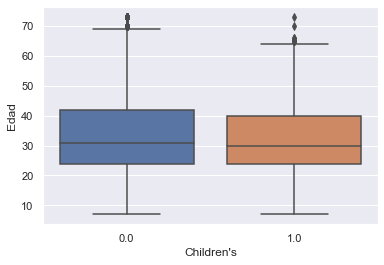

In [70]:
ax_L = sns.boxplot(x="Children's", y="Edad", data=df_ratings_L)

In [ ]:
ax_NS = sns.boxplot(x="day", y="total_bill", data=tips)

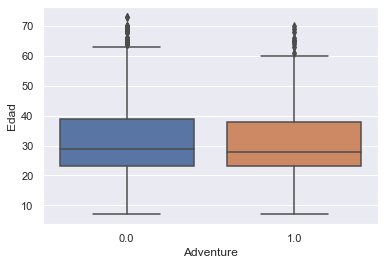

In [69]:
ax_P = sns.boxplot(x="Adventure", y="Edad", data=df_ratings_D)

### Pregunta 1.2

### Pregunta 1.3